In [71]:
import sys
import math
import os
import copy
import pandas as pd
import numpy as np
import shap
from datetime import datetime
from pathlib import Path

from scipy.stats import dirichlet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.tri as tri
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D

sys.path.append('..\..')

import simple_network_sim.common as common
import simple_network_sim.loaders as loaders
import simple_network_sim.network_of_populations as ss
from simple_network_sim.sampleUseOfModel import build_args, runSimulation

from data_pipeline_api.api import API
from data_pipeline_api.file_system_data_access import FileSystemDataAccess

In [3]:
def generate_random_state_transitions(compartment_transition, population_concentration=10.):

    random_compartment_transition = compartment_transition.copy()

    def func(x):
        return pd.DataFrame(np.random.dirichlet(x.rate * population_concentration), index=x.dst, columns=["rate"])

    random_compartment_transition = random_compartment_transition.groupby(["age", "src"]).apply(func).reset_index()
                
    return random_compartment_transition

def generate_random_mixing_matrix(mixing_matrix, sigma=1.):
    
    random_mixing_matrix = mixing_matrix.copy()
    random_mixing_matrix.mixing = random_mixing_matrix.mixing.apply(lambda x: np.random.lognormal(np.log(x) - 0.5 * sigma**2, sigma))

    return random_mixing_matrix

def generate_random_infection_probability(infection_probability):
    
    infection_probability = infection_probability.copy()
    infection_probability.loc[0, "Value"] = np.random.beta(0.05, 0.95)
    
    return infection_probability


def aggregate_all_boards(results):
    return results.groupby(["time", "state"]).sum().reset_index().pivot(index="time", columns="state", values="total")


def create_network(compartment_transition=None, population=None, commutes=None, mixing_matrix=None, infectious_compartments=None, infection_probability=None, movement_multipliers=None):    
    return ss.createNetworkOfPopulation(
        api.read_table("human/compartment-transition", version=1) if compartment_transition is None else compartment_transition,
        api.read_table("human/population", version=1) if population is None else population,
        api.read_table("human/commutes", version=1) if commutes is None else commutes,
        api.read_table("human/mixing-matrix", version=1) if mixing_matrix is None else mixing_matrix,
        api.read_table("human/infectious-compartments", version=1) if infectious_compartments is None else infectious_compartments,
        api.read_table("human/infection-probability", version=1) if infection_probability is None else infection_probability,
        api.read_table("human/movement-multipliers", version=1) if movement_multipliers is None else movement_multipliers,
    )

In [4]:
parent_dir = Path(os.path.abspath('')).parents[1]
api = API(FileSystemDataAccess(str(parent_dir / "data_pipeline_inputs"), "metadata.toml"))

initial_infections = [loaders.readInitialInfections(api.read_table("human/initial-infections", version="1"))]

network = create_network()

max_time = 200
trials = 1

# Introduction - Non linear parameter sensitivity analysis

For helping identifying the impactful parameters, and how they impact the final number of deaths and infected, the first approach at the impact of changing parameters one by one (https://github.com/ScottishCovidResponse/simple_network_sim/blob/master/doc/notebooks/Parameter%20sensitivity%20analysis.ipynb). However, only looking at marginal impact from parameters would miss the importance of non linear and cross effects, which might be very important for complex black box models, but also harder to measure. In this notebook we describe a methodology based on non-linear regressions to approximate the black box model and understand its inner interactions.

It relies on:
1) Generating many tuples of parameters (compartment transition matrix, mixing matrix, movement multipliers, etc)

2) Generating model outputs for each of these parameter tuples (e.g. total number of deaths, of infections)

3) Fit a non linear regression model (e.g. ExtraTree Regressor, XGBoost) mapping the parameters to the ouput

4) Get the feature importance from the non linear model

5) Analyze the feature dependance plots through SHAP

# 1) Finding a prior for compartment transition matrix

In [6]:
df = api.read_table("human/compartment-transition", version=1)

pd.pivot_table(df, values="rate", index="dst", columns=["age", "src"]).style.set_precision(2).background_gradient("Reds", high=0.5).highlight_null("black")

Firstly, we need to generate samples for the compartment transition matrix, from a prior distribution. Because the transition probabilities from each state are linked (in that they should sum to 1. for all outgoing states), we need to use a Dirichlet prior (https://en.wikipedia.org/wiki/Dirichlet_distribution), typically used in this case, it is the conjugate prior distribution of categorical and multinomial distributions. The Dirichlet distribution's support is defined over sets of variables that have to sum up to 1 - a set of distributions. It also means a random sample from a Dirichlet distribution defined a categorical distribution.

E.g. when in the state "Infected" (I), and individual can transition in any of (I, R, D, H). The probabilities are currently set respectively to (0.67, 0.13, 0.05, 0.15). A dirichlet prior centered around these values allows one to generate similar probabilities, that still sum up to 1. Below we analyze a simple example of 3 probabilities which helps us understand how the distribution behaves. 

In [7]:
def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    AREA = 0.5 * 1 * 0.75**0.5
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    coords = np.clip(coords, tol, 1.0 - tol)
    coords[-1] = coords[-1] - (np.sum(coords) - 1.)
    return coords
    
def draw_pdf_contours(alphas, ax, nlevels=200, subdiv=8, **kwargs):

    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dirichlet.pdf(xy2bc(xy), alphas) for xy in zip(trimesh.x, trimesh.y)]

    ax.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    ax.axis('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.75**0.5)
    ax.axis('off')
    ax.set_title(f"Alphas: {str(alphas)}")

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

We graph the density of a dirichlet distribution, parametrized by $(\alpha_1, ..., \alpha_k)$, with mean $\left(\frac{\alpha_1}{\sum_i \alpha_i}, ..., \frac{\alpha_k}{\sum_i \alpha_i}\right)$. Small values of parameters make the distribution more peaked around its edges, while large ones make it more peaked around it's average. Because multiplying all $\alpha_i$ by a constant (which we dub concentration ratio) does not change it's average but only the spread, we will justify using a concentration ratio of 10. in order to generate some spread.

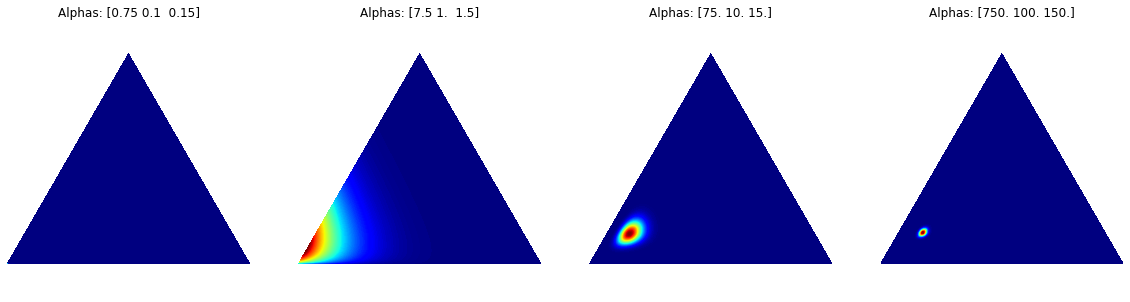

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
draw_pdf_contours(np.array([0.75, 0.1, 0.15]) * 1., axes[0])
draw_pdf_contours(np.array([0.75, 0.1, 0.15]) * 10., axes[1])
draw_pdf_contours(np.array([0.75, 0.1, 0.15]) * 100., axes[2])
draw_pdf_contours(np.array([0.75, 0.1, 0.15]) * 1000., axes[3])

# 2) Finding a prior for the mixing matrix

Finding a prior for the mixing matrix is much simpler, all values only have the constraints of being positive and are unrelated to each other. We use simple lognormal priors, centered around current point estimates, with a standard deviation of 0.5.

In [9]:
df = api.read_table("human/mixing-matrix", version=1)
pd.pivot_table(df, values="mixing", index="source", columns="target").style.set_precision(2).background_gradient("Reds", high=0.5)

target,70+,"[0,17)","[17,70)"
source,,,
70+,0.08,0.04,0.27
"[0,17)",0.10,2.16,1.64
"[17,70)",0.18,0.54,2.29


# 3) Finding a prior for the infection probability

Being a probability, we will use a Beta distribution centered around 5%. We recall the expectation of a Beta distribution parametrized by $(a, b)$ as $\frac{a}{b+a}$.

In [10]:
api.read_table("human/infection-probability", version=1)

,Time,Value
0,0,1.0


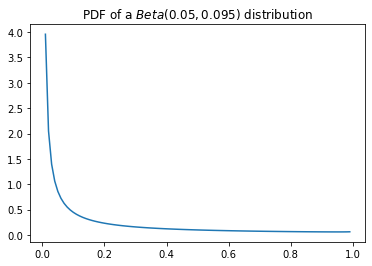

In [11]:
from scipy.stats import beta
x = np.arange (0.01, 1, 0.01)
y = beta.pdf(x, 0.05, 0.95)
plt.plot(x, y);
plt.title("PDF of a $Beta(0.05, 0.095)$ distribution");

# 3) Random parameter generation

Using the settings and parameters above we generate 10000 samples of random parameters to be used for generating model results.

In [12]:
np.random.seed(seed=33)
n = 10000
population_concentration = 10.
sigma = 0.5

compartment_transition = api.read_table("human/compartment-transition", version=1)
mixing_matrix = api.read_table("human/mixing-matrix", version=1)
infection_probability = api.read_table("human/infection-probability", version=1)

parameters = []
for _ in range(n):
    parameters.append({
        "progression": generate_random_state_transitions(compartment_transition, population_concentration),
        "mixing_matrix": generate_random_mixing_matrix(mixing_matrix, sigma),
        "infection_probability": generate_random_infection_probability(infection_probability),
    })

# 4) Generate model results

Next up we generate model runs for each of these random parameters. This takes a couple of hours.

In [13]:
compartment_transition = api.read_table("human/compartment-transition", version=1)
population = api.read_table("human/population", version=1)
commutes = api.read_table("human/commutes", version=1)
mixing_matrix = api.read_table("human/mixing-matrix", version=1)
infectious_compartments = api.read_table("human/infectious-compartments", version=1)
infection_probability = api.read_table("human/infection-probability", version=1)
movement_multipliers = api.read_table("human/movement-multipliers", version=1)

results = []
for parameter in parameters:
    random_network = create_network(compartment_transition=parameter["progression"], population=population, commutes=commutes, mixing_matrix=parameter["mixing_matrix"], 
                                    infectious_compartments=infectious_compartments, infection_probability=parameter["infection_probability"], movement_multipliers=movement_multipliers)
    res = runSimulation(random_network, max_time, trials, initial_infections)
    results.append(aggregate_all_boards(res))

# 5) Generate regression model inputs - X and Y matrices

In order to be able to use a regular non-linear regression model, we must condense model inputs (the parameters) and model outputs in a format which a model can read.

For input parameters, we simply assume every parameter used is a separate column (each compartment transition rate, each mixing matrix element, etc).

For output parameters, it is more complicated as the model originally outputs time series of number of people in each disease state. Most models cannot easily copy with time series. Therefore we will condense the results into point value: 
- Total number of deaths
- Total number of infected people

We assume these are the important values on which we wish to know the impact.

In [40]:
X = []
for parameter in parameters:
    res = {}
    progression = parameter["progression"]
    progression = progression[progression.age == "70+"]
    
    for _, row in progression.iterrows():
        res[f"{row.src}->{row.dst}"] = row.rate
                
    for _, row in parameter["mixing_matrix"].iterrows():
        res[f"{row.source}->{row.target}"] = row.mixing
    
    res["infection_probability"] = parameter["infection_probability"].Value[0]
    
    X.append(res)
    
X = pd.DataFrame(X)

In [43]:
Y = []
for result in results:
    Y.append({
        "deaths": result.D.max(),
        "infected": result.S.max() - result.S.min(),
    })
    
Y = pd.DataFrame(Y)

# 6) Fitting a non-linear regression model - ExtraTree regressor

In order to be able to approximate simple network sim using an external model, we need to use one which is flexible enough and satisfies the universal approximator property. Extra Tree Regressors (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html), in addition to satisfy the mentioned property, provide useful feature importance metrics which summarize how much parameters provide additional explanative power on all the trees. For a more detailed description please refer to (https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3).

In [119]:
XY = pd.concat([X, Y], axis=1)
print(len(XY))
XY = XY[XY.deaths < 1000]
print(len(XY))
XY = XY[XY.infected < 10000]
print(len(XY))
X_clean = XY.drop(["infected", "deaths"], axis=1)
Y_clean = XY[["infected", "deaths"]]

10000
9773
9626


The priors used are heavy tailed, so some random samples lead to unrealistic values (e.g. infection probability of 0.95), which causes large outliers in the number of deaths and infected. We remove them, so that the model (which focuses on minimizing MSE), doesn't depend on those too much. We might want to adjust the priors later on to avoid this.

In [120]:
ms_list = np.unique(np.round(np.logspace(np.log10(2.0), np.log10(np.min([1000, len(X) / 2])), 10)).astype(int))

cv_infected = GridSearchCV(
    estimator=ExtraTreesRegressor(n_estimators=100, criterion='mse', max_depth=None, bootstrap=True, oob_score=False, random_state=123),
    param_grid={
        'min_samples_split': ms_list,
        'max_features': [int(1), 0.33, 1.0]
    },
    scoring='r2'
).fit(X_clean, Y_clean["infected"])

print(f"min_samples_split: {cv_infected.best_params_['min_samples_split']}")
print(f"max_features: {cv_infected.best_params_['max_features']}")

min_samples_split: 8
max_features: 1.0


In [121]:
model_infected = ExtraTreesRegressor(n_estimators=1000, criterion='mse', max_depth=None, bootstrap=True, oob_score=False, min_samples_split=cv_infected.best_params_['min_samples_split'], max_features=cv_infected.best_params_['max_features'], random_state=123)
model_infected.fit(X_clean, Y_clean["infected"])
print(cross_val_score(model_infected, X_clean.values, Y_clean["infected"], cv=4, scoring="r2"))

[0.69540866 0.75357581 0.59004691 0.66222849]


In [122]:
cv_deaths = GridSearchCV(
    estimator=ExtraTreesRegressor(n_estimators=100, criterion='mse', max_depth=None, bootstrap=True, oob_score=False, random_state=123),
    param_grid={
        'min_samples_split': ms_list,
        'max_features': [int(1), 0.33, 1.0]
    },
    scoring='r2'
).fit(X_clean, Y_clean["deaths"])

print(f"min_samples_split: {cv_deaths.best_params_['min_samples_split']}")
print(f"max_features: {cv_deaths.best_params_['max_features']}")

min_samples_split: 251
max_features: 1.0


In [123]:
model_deaths = ExtraTreesRegressor(n_estimators=1000, criterion='mse', max_depth=None, bootstrap=True, oob_score=False, min_samples_split=cv_deaths.best_params_['min_samples_split'], max_features=cv_deaths.best_params_['max_features'], random_state=123)
model_deaths.fit(X_clean, Y_clean["deaths"])
print(cross_val_score(model_deaths, X_clean.values, Y_clean["deaths"], cv=4, scoring="r2"))

[0.1298241  0.15011482 0.14835905 0.13660477]


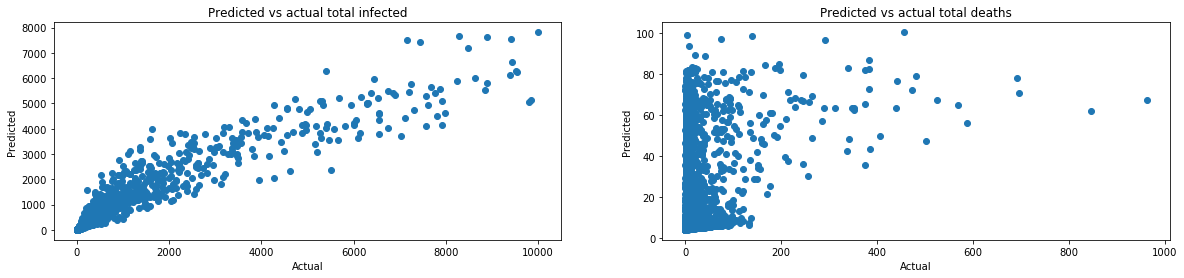

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
axes[0].scatter(Y_clean["infected"], model_infected.predict(X_clean))
axes[0].set_title("Predicted vs actual total infected")
axes[0].set_xlabel("Actual");
axes[0].set_ylabel("Predicted");

axes[1].scatter(Y_clean["deaths"], model_deaths.predict(X_clean))
axes[1].set_title("Predicted vs actual total deaths")
axes[1].set_xlabel("Actual");
axes[1].set_ylabel("Predicted");

Our ExtraTree regressor model can explain roughly 40% of the variance generated by simple network sim (this R2 is computed in a 5-fold cross validation setup)

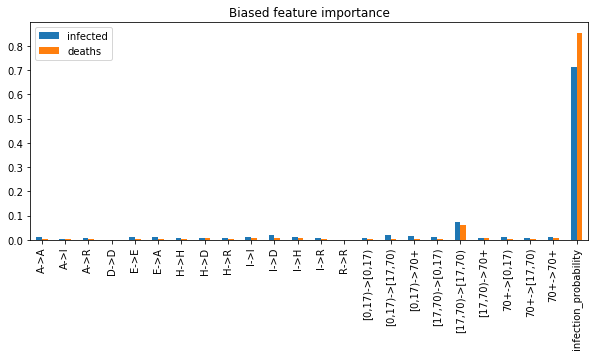

In [126]:
imp = [
    model_infected.feature_importances_ / model_infected.feature_importances_.sum(),
    model_deaths.feature_importances_ / model_deaths.feature_importances_.sum(),
]
    
imp = pd.DataFrame(data=np.array(imp), index=["infected", "deaths"], columns=X.columns).T

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
imp.plot.bar(ax=ax, title='Biased feature importance');

Unsurprisingly, the most impactful features are:
- The probability of staying asymptomatic when being asymptomatic
- The probability of recovering when being asymptomatic
- The mixing matrix between the age group [17, 70] and itself, asa it's the largest in number

# 7) SHAP graphs

SHAP graphs are a cutting edge way to visualize the non-linear interactions in a black box model. It is described in (https://github.com/slundberg/shap, and https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf provides a technical explanation).

They allow visualization of:
- The marginal impact of a feature
- The impact from all other features on a given feature
- The impact of the most impactful other feature

One can read a given graph in the following way:
- On the x-axis is the range of a given feature
- All data points in the sample (here 10000) are shown
- On the y-axis is the SHAP value: the contribution of adding this feature to the total ouput value (number of deaths), for each specific datapoint. Therefore the y-axis is in units of additional number of deaths
- The vertical dispersion for a given x-value shows the impact of all the other feature. If the vertical dispersion is high, this means that for this value of the feature, all other ones are very impactful and high order effects are high
- Finally, the coloring shows the values of another feature (the model picks the feature one that has most marginal impact over the feature under consideration)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


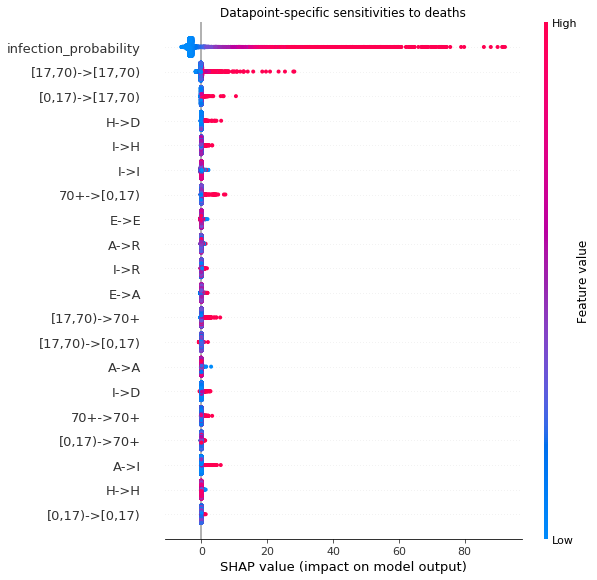

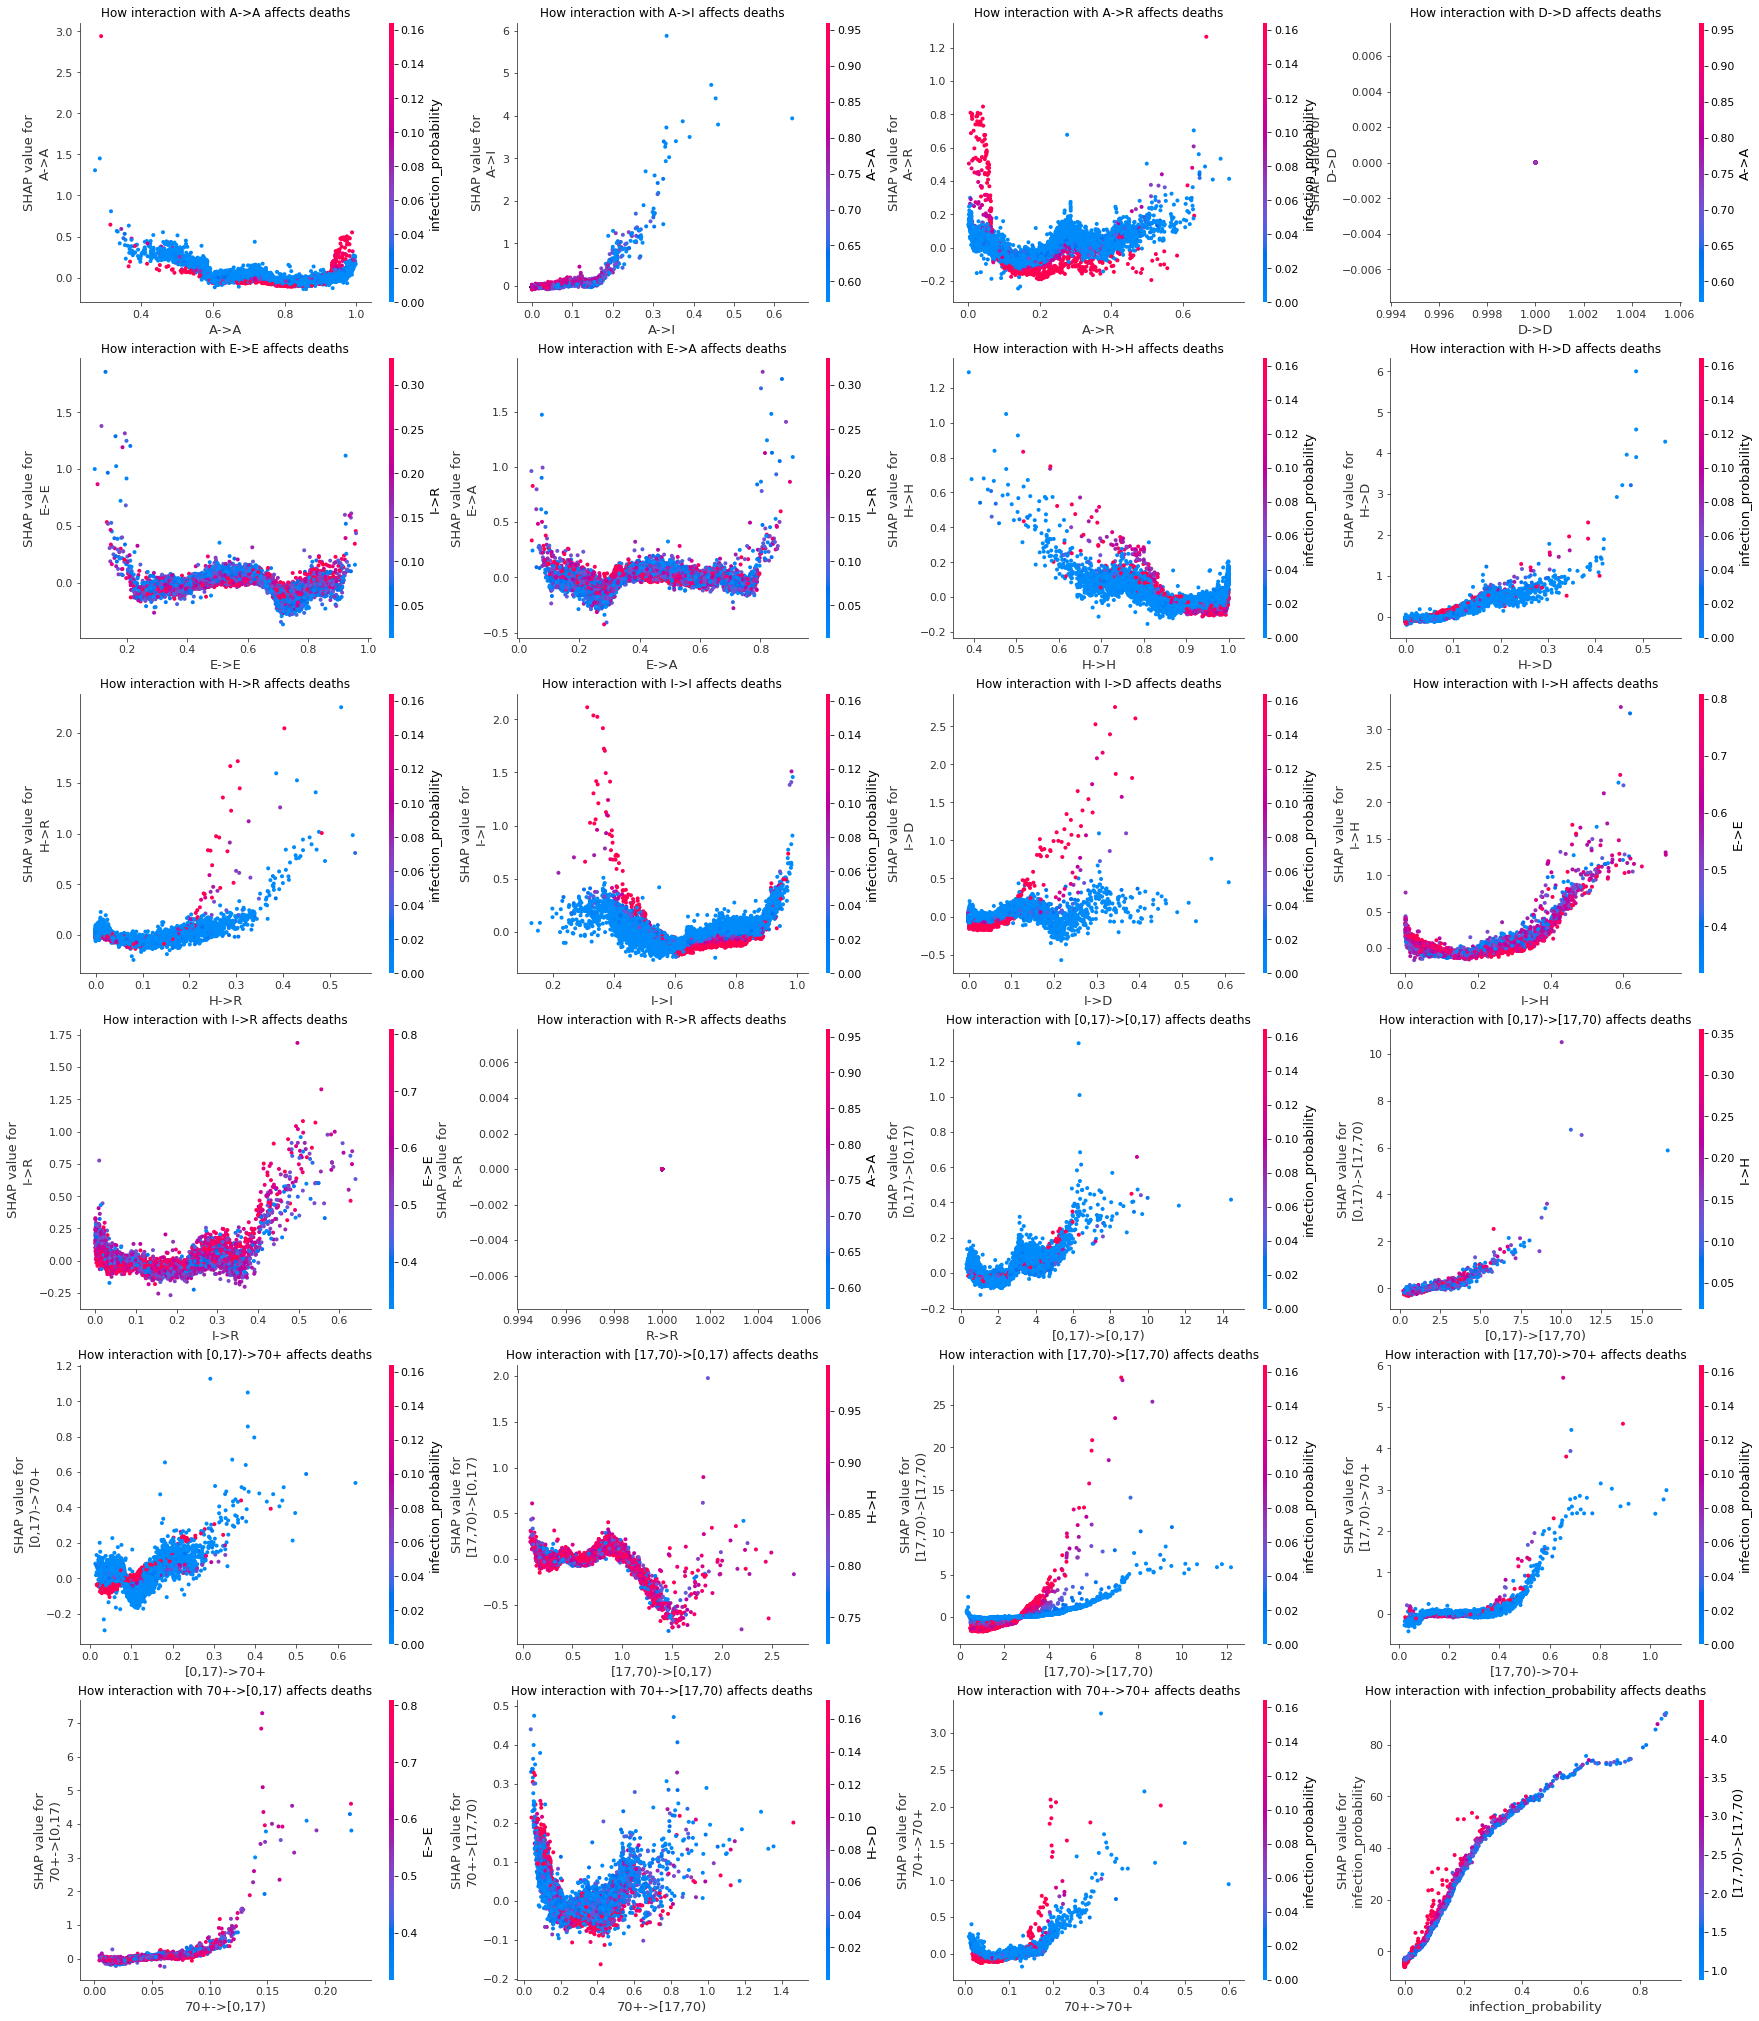

In [127]:
model = ExtraTreesRegressor(n_estimators=500, criterion='mse', max_depth=None, bootstrap=True, oob_score=True, min_samples_split=cv_deaths.best_params_['min_samples_split'], max_features=cv_deaths.best_params_['max_features'], random_state=123).fit(X_clean, Y_clean['deaths'])
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_clean)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_clean, show=False)
plt.title('Datapoint-specific sensitivities to deaths')

fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(30, 36))
for i, xcol in enumerate(X.columns):
    shap.dependence_plot(xcol, shap_values, X_clean, show=False, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title('How interaction with {} affects deaths'.format(xcol))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


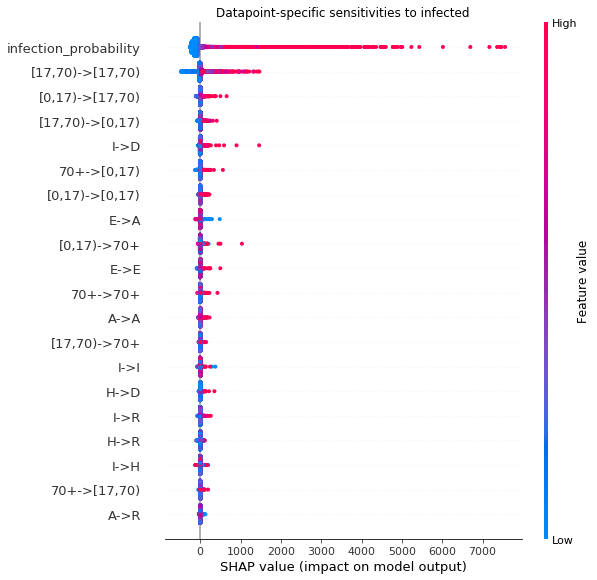

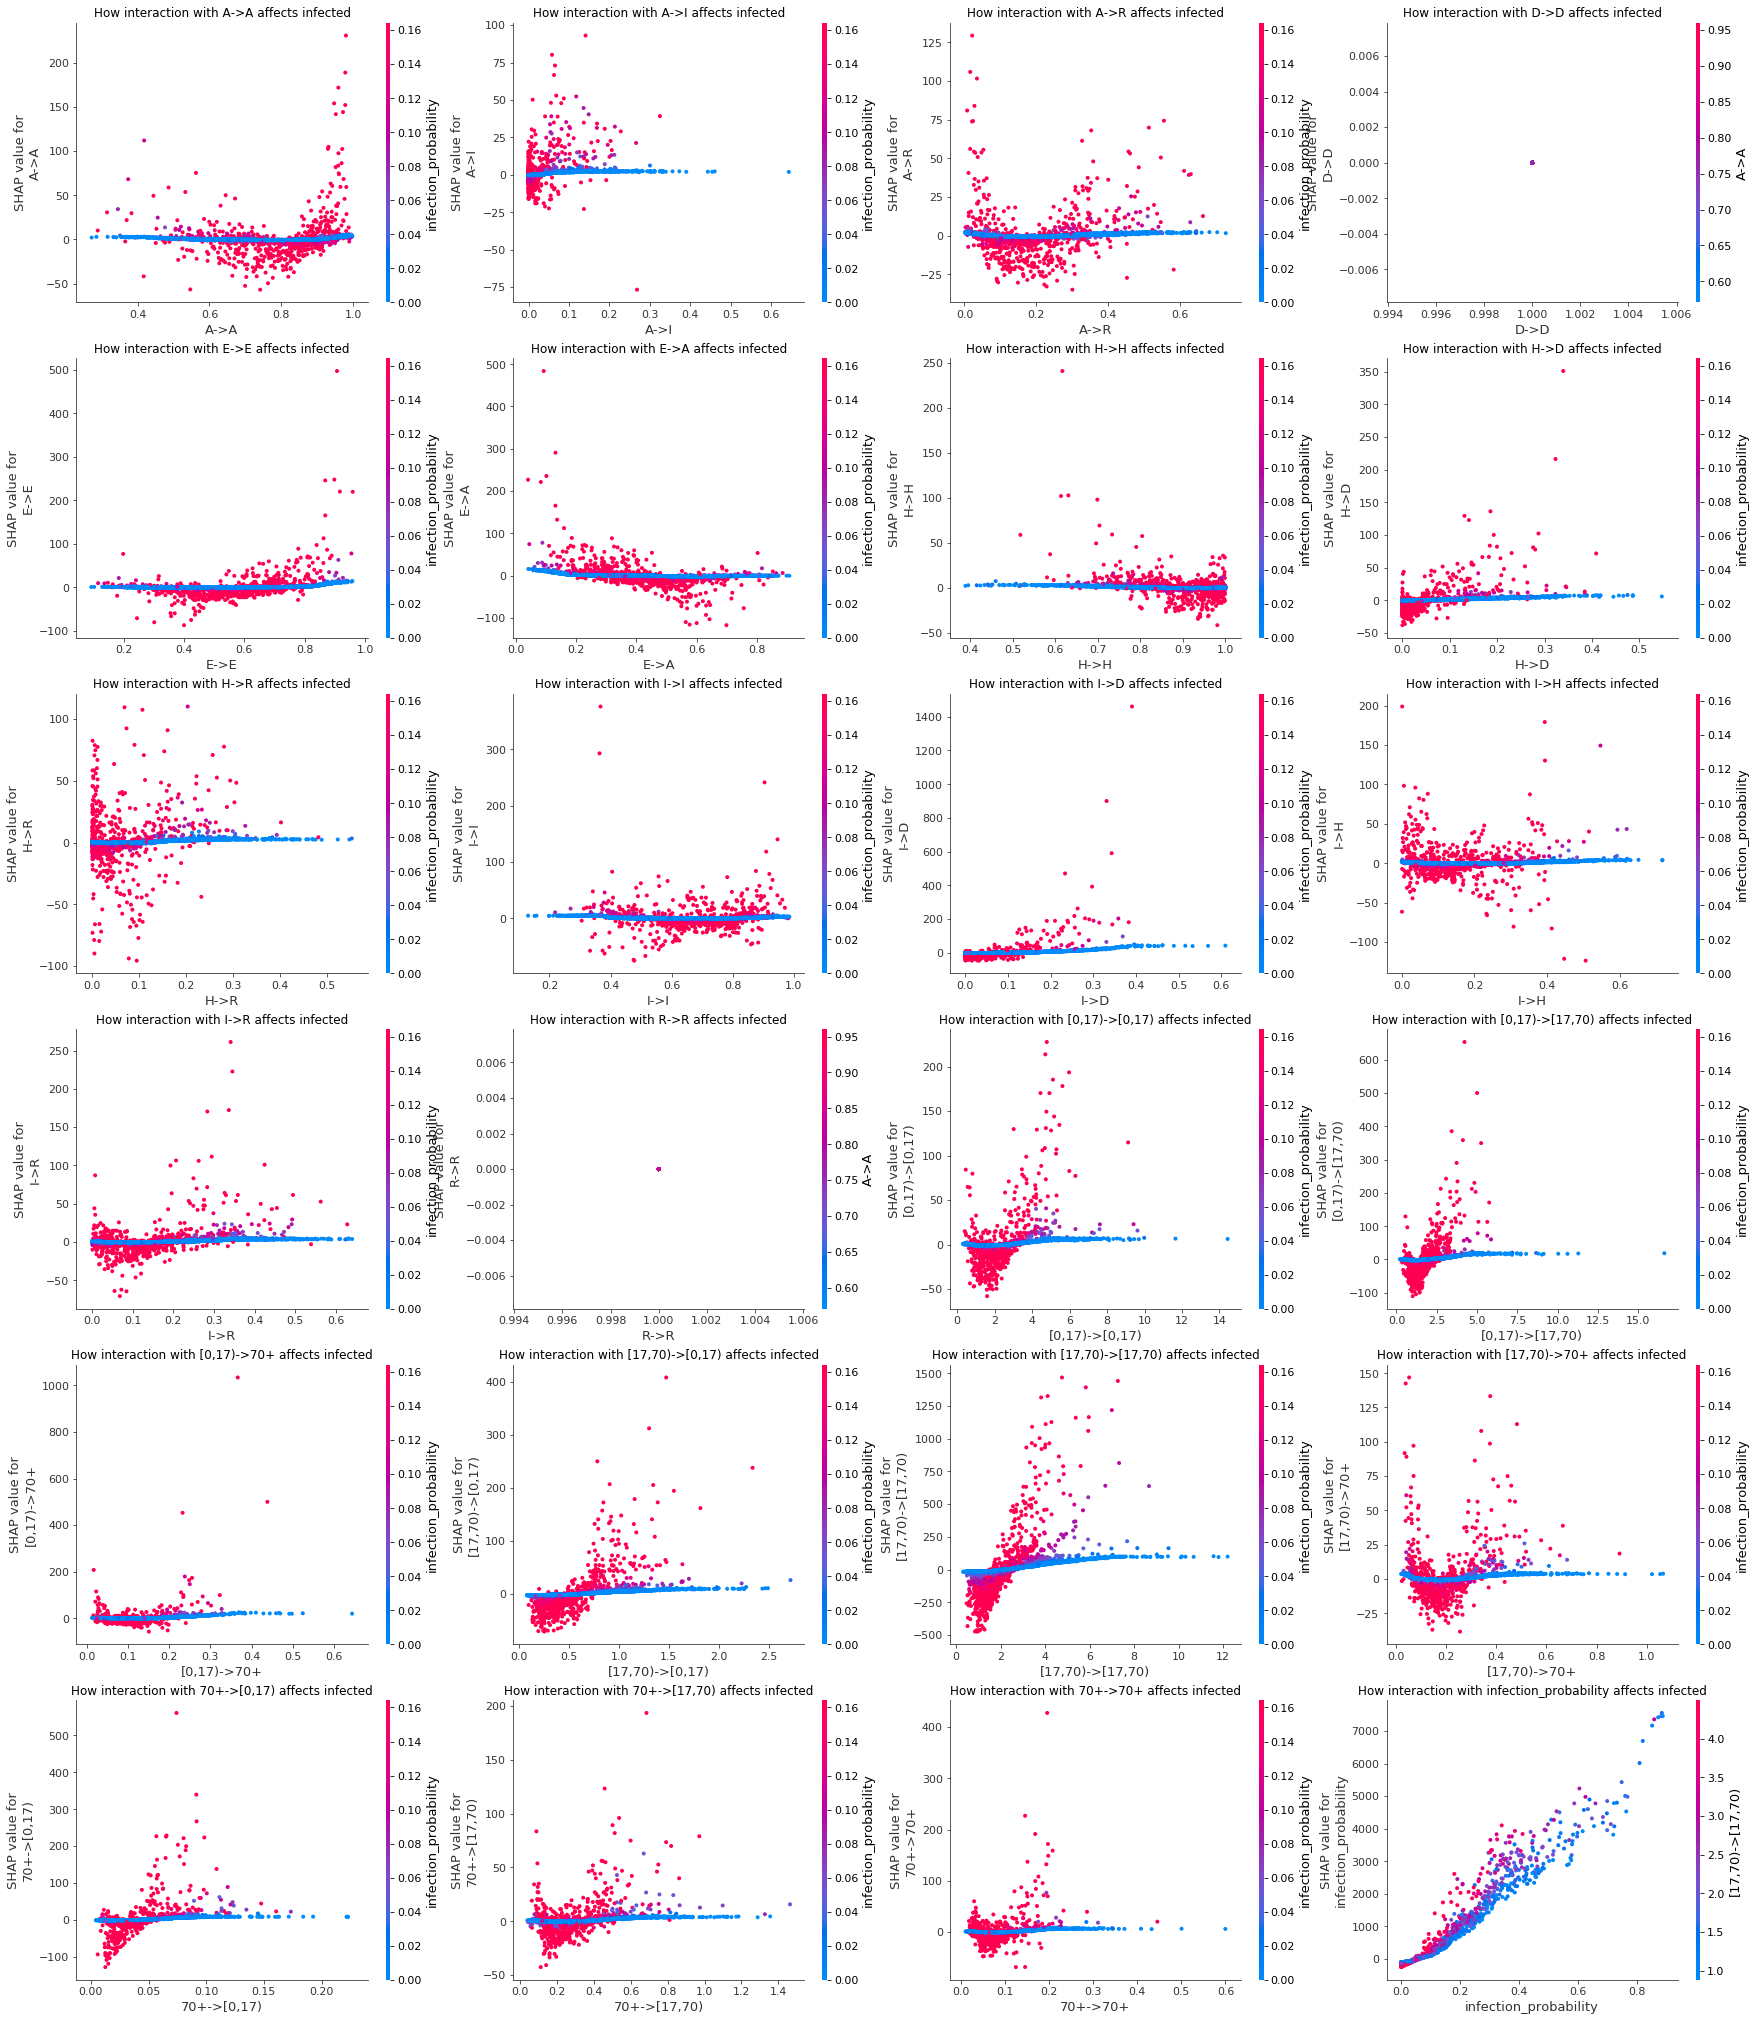

In [128]:
model = ExtraTreesRegressor(n_estimators=500, criterion='mse', max_depth=None, bootstrap=True, oob_score=True, min_samples_split=cv_infected.best_params_['min_samples_split'], max_features=cv_infected.best_params_['max_features'], random_state=123).fit(X_clean, Y_clean['infected'])
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_clean)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_clean, show=False)
plt.title('Datapoint-specific sensitivities to infected')

fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(30, 36))
for i, xcol in enumerate(X.columns):
    shap.dependence_plot(xcol, shap_values, X_clean, show=False, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title('How interaction with {} affects infected'.format(xcol))